# Chương 0: Phân tích Chuỗi Thời gian Nâng cao (Advanced Time Series Analysis)

Biên soạn bởi: Benjur Emmanuel L. Borja, Sebastian C. Ibañez và Maria Eloisa M. Ventura

Notebook này giới thiệu cho chúng ta về khái niệm chuỗi thời gian, dự báo và các kiến thức nền tảng khác nhau mà chúng ta sẽ sử dụng xuyên suốt các chương tiếp theo của thảo luận. Cụ thể, notebook này sẽ đề cập đến:
1. Chuỗi thời gian
1. Dự báo
1. Quá trình ngẫu nhiên

Nội dung của notebook này được tổng hợp từ các tài liệu tham khảo sau:
- C.Monterola, *"Notebook 10 Time Series Forecasting Method --- ARIMA MSDS2021"*
- C.Monterola, *"Advanced Time Series Analysis - Recurrent Neural Networks --- PhDinDS2023"*  
- J.Valenzuela, *"Advanced Time Series Analysis --- PhDinDS2023"*


In [1]:
# Required Libraries
import numpy as np
import numpy.random as rng
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as tg
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 2]

## 1. Giới thiệu chung

Hầu hết chúng ta đều đã nghe về xu hướng mới trên thị trường, đó là Tiền mã hóa (Cryptocurrency). Nhiều người trong chúng ta cũng đã đầu tư vào các đồng tiền này. Nhưng, liệu việc đầu tư vào một loại tiền tệ biến động mạnh như vậy có an toàn không? Làm sao chúng ta có thể chắc chắn rằng đầu tư vào các đồng tiền này bây giờ sẽ mang lại lợi nhuận tốt trong tương lai? Chúng ta không thể chắc chắn, nhưng chúng ta hoàn toàn có thể ước lượng giá trị dựa trên các mức giá trước đó. Mô hình chuỗi thời gian là một cách để dự đoán chúng.

### Chuỗi thời gian là gì?

Chuỗi thời gian là một dãy các giá trị được đánh chỉ số, trong đó mỗi giá trị là _kết quả_ của một biến ngẫu nhiên. Nói cách khác, một chuỗi thời gian là một hiện thực hóa của một quá trình tương ứng.

Một ví dụ về chuỗi thời gian là bộ dữ liệu thời tiết được ghi lại tại Trạm Thời tiết của Viện Hóa sinh Max Planck ở Jena, Đức. Trong bộ dữ liệu này, 14 đại lượng khác nhau (như nhiệt độ không khí, áp suất khí quyển, độ ẩm, hướng gió, v.v.) được ghi lại mỗi 10 phút, trong nhiều năm. Dữ liệu gốc bắt đầu từ năm 2003, nhưng ví dụ này chỉ giới hạn trong dữ liệu từ 2009–2016. Bộ dữ liệu này rất phù hợp để học cách làm việc với chuỗi thời gian số. Chúng ta sẽ sử dụng bộ dữ liệu này để xây dựng các mô hình. Dưới đây là các biến thực tế trong dữ liệu:

- Date Time   
- p (mbar) áp suất khí quyển  
- T (degC) nhiệt độ  
- Tpot (K) nhiệt độ tiềm năng  
- Tdew (degC) nhiệt độ điểm sương  
- rh (%) độ ẩm tương đối  
- VPmax (mbar) áp suất hơi nước bão hòa  
- VPact (mbar) áp suất hơi nước thực tế  
- VPdef (mbar) độ thiếu hụt áp suất hơi nước  
- sh (g/kg) độ ẩm riêng  
- H2OC (mmol/mol) nồng độ hơi nước  
- rho (g/$m^3$) mật độ không khí  
- wv (m/s) vận tốc gió  
- max. wv (m/s) vận tốc gió lớn nhất  
- wd (deg) hướng gió  

Dưới đây là dữ liệu nhiệt độ từ bộ dữ liệu này mà chúng ta sẽ sử dụng thường xuyên trong các chương tiếp theo:

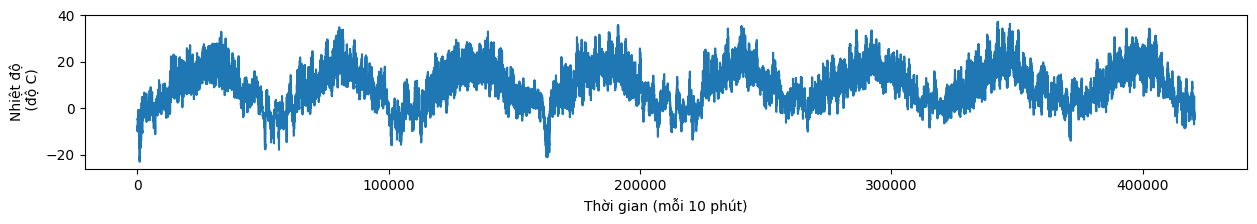

In [2]:
data = pd.read_csv('../data/jena_climate_2009_2016.csv')
data = data.iloc[:, 1:].astype(float).to_numpy()
temp = data[:, 1]  #nhiệt độ (đơn vị độ C)
plt.figure(figsize=(15,2))
plt.plot(range(len(temp)), temp)
plt.ylabel('Nhiệt độ\n (độ C)')
plt.xlabel('Thời gian (mỗi 10 phút)')
plt.show()

Chuỗi thời gian là bất kỳ thứ gì đã được ghi lại tuần tự theo thời gian -- có thể đều đặn hoặc không đều đặn. Dù trong trường hợp nào, mục tiêu là xem liệu các mẫu quan sát được có thể giúp chúng ta ***dự báo*** một khoảng thời gian trong tương lai hay không.

## 2. Dự báo chuỗi thời gian
Dự báo là việc dự đoán các giá trị tương lai của chuỗi thời gian dựa trên tất cả thông tin sẵn có như dữ liệu lịch sử và bất kỳ biến số nào có thể ảnh hưởng đến dữ liệu. Ngoài tiền mã hóa, còn có nhiều lĩnh vực quan trọng khác sử dụng dự báo chuỗi thời gian, ví dụ: dự báo doanh số bán hàng, lưu lượng cuộc gọi tại trung tâm chăm sóc khách hàng, hoạt động của mặt trời, thủy triều đại dương, biến động thị trường chứng khoán, và nhiều lĩnh vực khác. Giả sử một quản lý khách sạn muốn dự đoán số lượng khách sẽ đến vào năm sau để điều chỉnh tồn kho của khách sạn và ước tính doanh thu hợp lý. Dựa trên dữ liệu của các năm/tháng/ngày trước đó, (cô/anh) ấy có thể sử dụng dự báo chuỗi thời gian để ước lượng số lượng khách. Giá trị dự báo này sẽ giúp khách sạn quản lý nguồn lực và lên kế hoạch phù hợp.

Có rất nhiều yếu tố cần xem xét trước khi dự báo chuỗi thời gian:
1. Loại dữ liệu (Xu hướng, Tính mùa vụ, v.v.)
1. Các yếu tố ảnh hưởng (Phân tích đa biến, Quan hệ nhân quả, v.v.)
1. Lượng dữ liệu sẵn có

Trong các chương tiếp theo, chúng ta sẽ thảo luận về các phương pháp dự báo khác nhau và cách chúng được sử dụng. Mỗi phương pháp đều có những giả định và giới hạn riêng, nhưng ý tưởng chung là chúng ta giả định rằng có một quá trình toán học cơ bản xác định chuỗi thời gian của mình. Hiểu được các quá trình toán học này sẽ giúp chúng ta tìm ra phương pháp hoặc thuật toán phù hợp nhất (và các siêu tham số tương ứng) để dự báo chuỗi thời gian tốt hơn.

Ở phần tiếp theo, chúng ta sẽ thảo luận về cách xây dựng bộ dữ liệu chuỗi thời gian đầu tiên, đó là ***Quá trình ngẫu nhiên (Stochastic Processes)***.

## 3. Quá trình ngẫu nhiên

Một quá trình ngẫu nhiên, hay còn gọi là quá trình xác suất (sau đây gọi là quá trình), là một dãy các biến ngẫu nhiên được đánh chỉ số. Trong bối cảnh phân tích chuỗi thời gian, chúng ta sẽ sử dụng $t = 0, 1, 2, ...$ (thời gian rời rạc) làm chỉ số.

$\lbrace \mathbf{X_0}, \mathbf{X_1}, \mathbf{X_2}, ...\rbrace$ biểu diễn một quá trình mà trong đó $\mathbf{X_0}, \mathbf{X_1}, \mathbf{X_2}, ...$ là các biến ngẫu nhiên.

Một chuỗi thời gian, trong bối cảnh này, là một dãy các giá trị được đánh chỉ số, trong đó mỗi giá trị là _kết quả_ của một biến ngẫu nhiên. Nói cách khác, một chuỗi thời gian là một hiện thực hóa của một quá trình tương ứng.

__Ví dụ 1: Thử nghiệm Bernoulli.__ Nhớ lại rằng một thử nghiệm Bernoulli có hai khả năng kết quả hoặc hiện thực. Ta lấy chúng là $\{-1, +1\}$. Hãy tạo ra một vài giá trị:

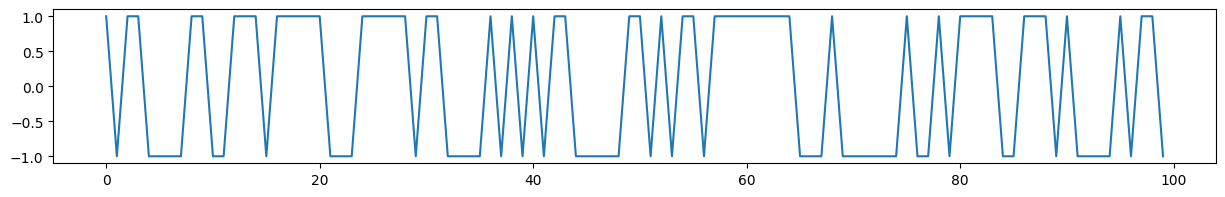

In [3]:
# Kết quả có thể của Bernoulli
bern_outcomes = [-1., 1.]
size = 100
# Sinh 100 phép thử Bernoulli
flips = rng.choice(bern_outcomes, size=size)
series = pd.Series(flips)
fig, ax = plt.subplots(figsize=(15, 2))
series.plot(ax=ax) # ở đây chúng ta ngầm định đánh chỉ số; để chỉ số đại diện cho thời gian
plt.show()

__Ví dụ 2: Nhiễu trắng Gauss.__ Một quá trình nhiễu trắng Gauss tạo ra một chuỗi thời gian mà mỗi giá trị được lấy mẫu từ một phân phối Gauss với kỳ vọng bằng 0 và phương sai bằng 1: $\bf{X_t} \sim Gaussian(0, 1)$:

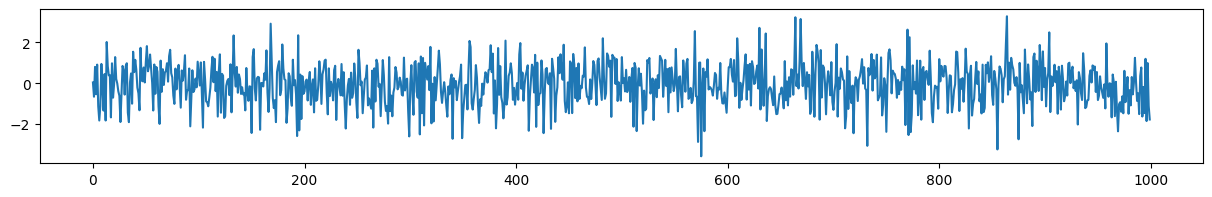

In [4]:
size = 1000
wn = st.norm.rvs(size=size)
wn_series = pd.Series(wn)
fig, ax = plt.subplots(figsize=(15, 2))
wn_series.plot(ax=ax)
plt.show()

Nhiễu trắng Gauss có các tính chất _độc lập_ và _phân phối đồng nhất_, điều này dẫn đến một số đặc điểm quan trọng cho các chuỗi thời gian tuyến tính, sẽ được đề cập bên dưới.

__Ví dụ 3: Chuyển động Brown một chiều.__ Chuyển động Brown một chiều, hay còn gọi là quá trình Wiener, có thể được xem như tổng tích lũy của chuỗi thời gian nhiễu trắng. Giá trị của chuỗi tại thời điểm $t$ là tổng của tất cả các giá trị trước đó, và có thể được hình dung như độ dịch chuyển của một người đi ngẫu nhiên tại thời điểm $t$: $X_t = X_{t_1} + X_{t-2}  + ... = \sum_{i=0}^{t}{X_i}$.

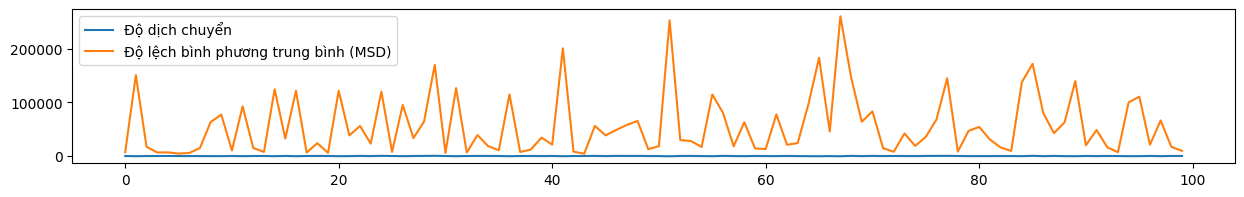

In [5]:
size = 100000
bms = []
bms_msq = []
for i in range(100):
    wn = st.norm.rvs(size=size)
    bm = np.cumsum(wn)
    bms.append(bm)
    bms_msq.append([x**2 for x in bm])
bm_ave = np.mean(bms, axis=1)
bm_msq = np.mean(bms_msq, axis=1)

fig, ax = plt.subplots(figsize=(15, 2))
bms_series = pd.Series(bm_ave)
bms_msq_series = pd.Series(bm_msq)
bms_series.plot(label="Độ dịch chuyển", ax=ax)
bms_msq_series.plot(label="Độ lệch bình phương trung bình (MSD)", ax=ax)
plt.legend()
plt.show()

__Ví dụ 4: Trung bình trượt.__ Với một quá trình nhiễu trắng (xem ở trên), một quá trình trung bình trượt bậc ($q$) có thể được tạo ra bằng cách lấy tổng có trọng số của giá trị hiện tại và $q$ giá trị trước đó của nhiễu trắng tại mỗi thời điểm $t$:

$X_t = \epsilon_t + a_1\epsilon_{t-1} + ... + a_q\epsilon_{t-q}$,

trong đó $\{\epsilon_t\} \sim WN(0, \sigma^2)$. Ta ký hiệu $\{X_t\} \sim MA(q)$. Quá trình $MA$ là một ví dụ về _quá trình tuyến tính._

Hãy xét một quá trình $MA(2)$ với $a_1 = 0.5$ và $a_2 = 0.25$. Khi đó

$X_t = \epsilon_t + 0.5\epsilon_{t-1} + 0.25\epsilon_{t-2}$.

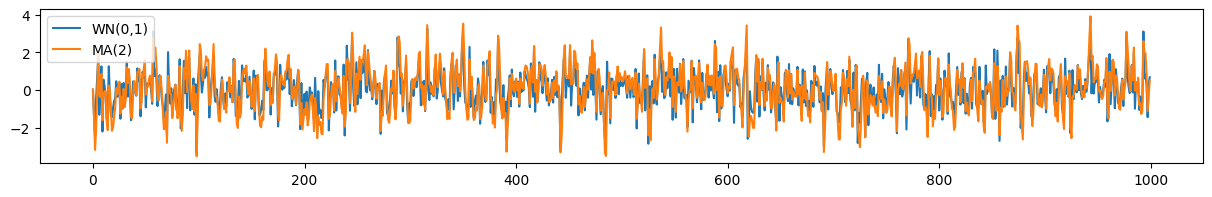

In [6]:
def ma2(wn):
    x = []
    # First element is just epsilon_t
    x.append(wn[0])
    # For the second element, let's take just the first coefficient (admittedly a judgment call)
    x.append(0.5*wn[0] + wn[1])
    # For the rest, use the full equation
    for t in range(2, len(wn)):
        x.append(wn[t] + 0.5*wn[t - 1] + 0.25*wn[t - 2])
    return np.array(x)

size = 1000
wn = st.norm.rvs(size=size)
ma2_series = pd.Series(
    ma2(wn)
)
wn_series = pd.Series(wn)
fig, ax = plt.subplots(figsize=(15, 2))
wn_series.plot(label="WN(0,1)", ax=ax)
ma2_series.plot(label=r"MA(2)", ax=ax)
plt.legend(loc="best")
plt.show()

__Bài tập 1: Quá trình tự hồi quy.__ Cho một quá trình nhiễu trắng (xem ở trên), một chuỗi thời gian từ quá trình tự hồi quy bậc $p$ có thể được tạo ra bằng cách lấy tổng có trọng số của $p$ giá trị trước đó của chuỗi thời gian, cộng với nhiễu trắng tại mỗi thời điểm $t$:

$X_t = b_{1}X_{t-1} + ... + b_{p}X_{t-p} + \epsilon_{t}$,

trong đó $\{\epsilon_t\} \sim WN(0, \sigma^2)$. Ta ký hiệu $\{X_t\} \sim MA(q)$.

Cho một quá trình $AR(2)$ với $b_1 = 0.6, b_2 = -0.2$, hãy sinh và vẽ đồ thị một chuỗi thời gian, tương tự ví dụ $MA(1)$ ở trên.

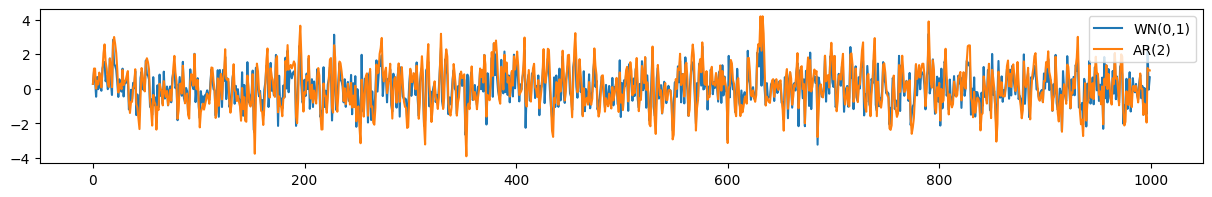

In [7]:
def ar2(wn):
    x = []
    # First element is just epsilon_t
    x.append(wn[0])
    # For the second element, let's take just the first coefficient (admittedly a judgment call)
    x.append(0.6*x[0] + wn[1])
    # For the rest, use the full equation
    for t in range(2, len(wn)):
        x.append(wn[t] + 0.6*x[t - 1] + -0.2*x[t - 2])
    return np.array(x)
        
size = 1000
wn = st.norm.rvs(size=size)
ar2_series = pd.Series(
    ar2(wn)
)
wn_series = pd.Series(wn)
fig, ax = plt.subplots(figsize=(15, 2))
wn_series.plot(label="WN(0,1)", ax=ax)
ar2_series.plot(label=r"AR(2)",ax=ax)
plt.legend(loc="best")
plt.show()

### Tính dừng

Xét một quá trình $\{X_t\}$, với phân phối kết hợp tương ứng $P(X_{t_1 + \tau}, X_{t_2 + \tau}, ..., X_{t_n + \tau})$ tại các thời điểm $t_1 + \tau, t_2 + \tau, ..., t_n + \tau$.

Quá trình này là _dừng_ nếu:

$P(X_{t_1 + \tau}, X_{t_2 + \tau}, ..., X_{t_n + \tau}) = P(X_{t_1}, X_{t_2}, ..., X_{t_n})$ với mọi $\tau, t_1 ... t_n$ và $n$.

Về cơ bản, các thống kê của một quá trình dừng là bất biến theo phép tịnh tiến thời gian.

$\{X_t\}$ là _dừng yếu_ nếu:

(i) $\mu(X_t) = \mu(X_{t + \tau}) = \mu$ với mọi $\tau$,\
(ii) $\Gamma(t_1, t_2) = \Gamma(t_1 - t_2)$, và\
(iii) $E[|X_t|^2] < \infty$.

Ở trên, $\Gamma(t_1, t_2)$ là _hiệp phương sai tự động_ (autocovariance), được định nghĩa bởi:

$\Gamma(t_1, t_2) = cov~(t_1, t_2) = E\left[(X_{t_1} - \mu(X_{t_1}))(X_{t_2} - \mu(X_{t_2}))\right]$

Tính dừng yếu ngụ ý rằng độ trễ, $\tau$, có thể được sử dụng để tham số hóa hiệp phương sai tự động, dẫn đến:

$\Gamma(\tau)  = E\left[(X_t - \mu)(X_{t + \tau} - \mu)\right]$.

Chuẩn hóa hiệp phương sai tự động theo độ lệch chuẩn tại $t_1$ và $t_2$ sẽ cho _tự tương quan_ (autocorrelation):

$P(t_1, t_2) = \frac{cov~(t_1, t_2)}{\sigma_{t_1}\sigma_{t_2}} = \frac{E\left[(X_{t_1} - \mu(X_{t_1}))(X_{t_2} - \mu(X_{t_2}))\right]}{\sigma_{t_1}\sigma_{t_2}}$

Và với một quá trình dừng yếu:

$P(\tau) = \frac{E\left[(X_t - \mu)(X_{t + \tau} - \mu)\right]}{\sigma^2}$

Đối với nhiễu trắng Gauss, tính dừng yếu kéo theo tính dừng, điều này không phải lúc nào cũng đúng với các quá trình khác.

### Hiệp phương sai tự động của một quá trình dừng

Ma trận hiệp phương sai tự động của một quá trình dừng có một dạng đặc biệt. Đặt $\tau = |t_1 - t_2|$ là _độ trễ_, với $n$ quan sát liên tiếp từ chuỗi thời gian ${X_t}$, ma trận hiệp phương sai tự động là ma trận đối xứng và xác định dương, được cho bởi:

$
    \Gamma_n = \begin{pmatrix}
                    \gamma_0 & \gamma_1 & \gamma_2 & \cdots & \gamma_{n-1} \\
                    \gamma_1 & \gamma_0 & \gamma_1 & \cdots & \gamma_{n-2} \\
                    \gamma_2 & \gamma_1 & \gamma_0 & \cdots & \gamma_{n-3} \\
                    \vdots   & \vdots   &  \vdots  & \ddots &  \vdots \\
                    \gamma_{n-1} & \gamma_{n-2} & \cdots & \gamma_{n-3} & \gamma_0
                \end{pmatrix}
$

Vì với một quá trình dừng, phương sai tại độ trễ bằng 0 là không đổi, nên _ma trận tự tương quan_ được cho bởi:

$
    P_n = \sigma^2\Gamma_n = \begin{pmatrix}
                    1 & \rho_1 & \rho_2 & \cdots & \rho_{n-1} \\
                    \rho_1 & 1 & \rho_1 & \cdots & \rho_{n-2} \\
                    \rho_2 & \rho_1 & 1 & \cdots & \rho_{n-3} \\
                    \vdots   & \vdots   &  \vdots  & \ddots &  \vdots \\
                    \rho_{n-1} & \rho_{n-2} & \cdots & \rho_{n-3} & 1
                \end{pmatrix}
$

_Hàm hiệp phương sai tự động_, $\Gamma(\tau)$, có thể được đọc trực tiếp từ các đường chéo của ma trận hiệp phương sai tự động; tương tự với _hàm tự tương quan_.

__Hỏi.__ Hàm tự tương quan của quá trình nhiễu trắng Gauss với kỳ vọng bằng 0 và phương sai bằng 1 là gì?

__Đáp.__ Vì các giá trị là độc lập và phân phối đồng nhất (iid), nên các giá trị không tương quan với nhau, do đó:

$P(\tau) = \delta_{\tau,0}$

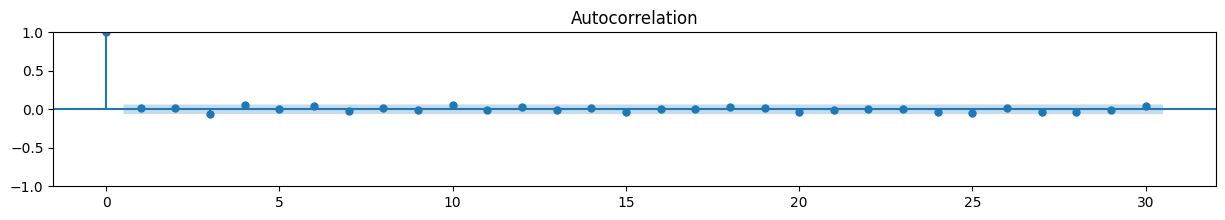

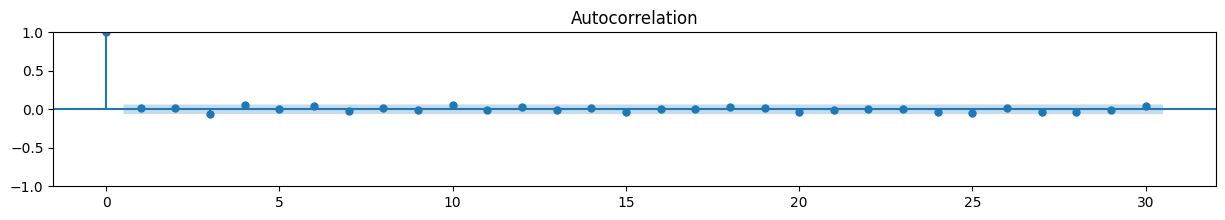

In [8]:
#Plotting:
tg.plot_acf(wn_series)

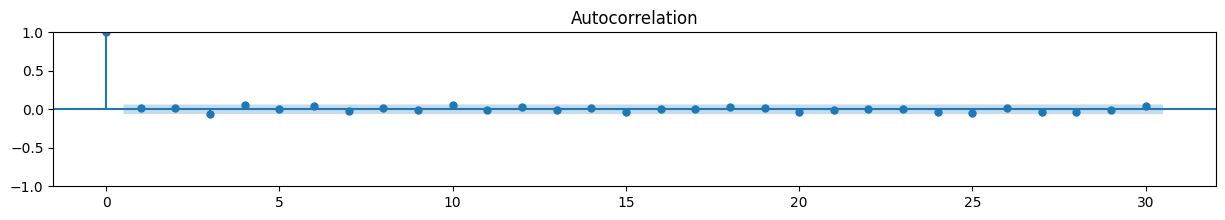

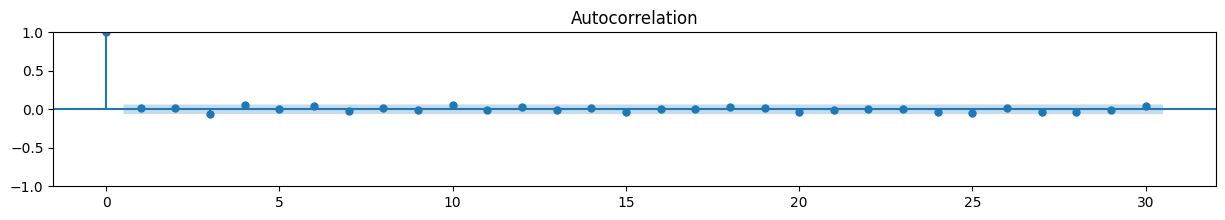

In [9]:
#Plotting:
tg.plot_acf(wn)

Tự tương quan cho các chuỗi thời gian khác ở trên:

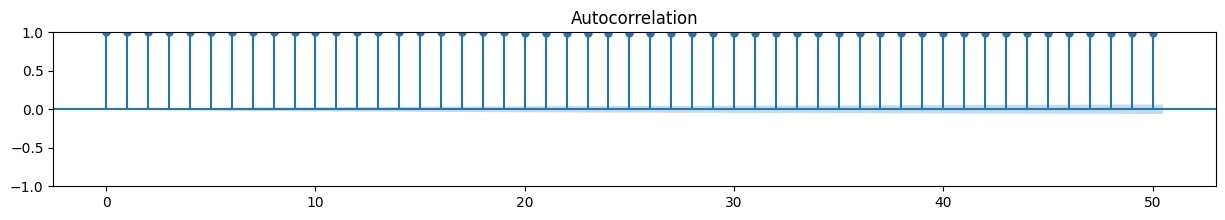

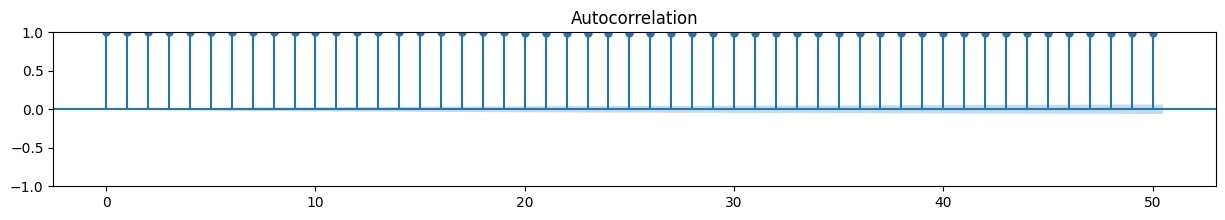

In [10]:
tg.plot_acf(bm)

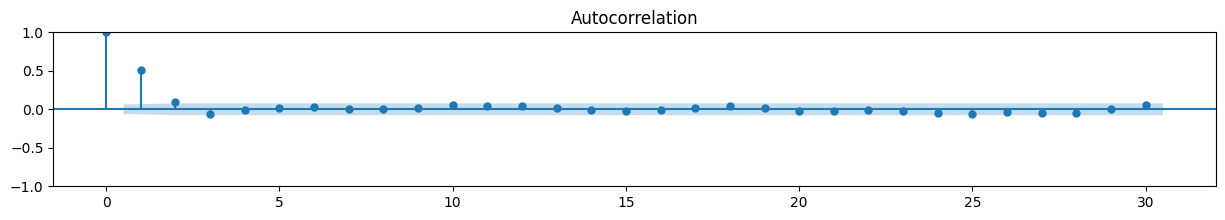

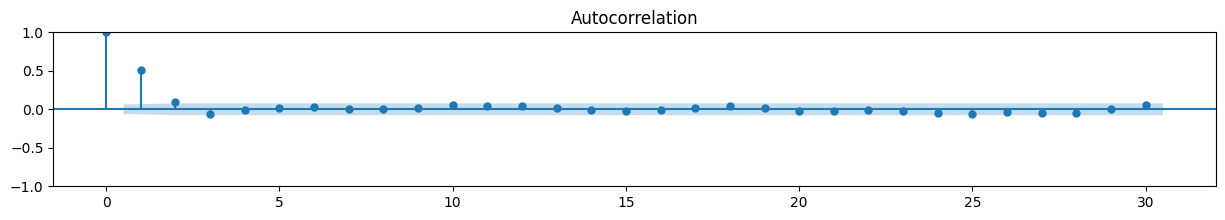

In [11]:
tg.plot_acf(ar2_series)

Tự tương quan của quá trình $AR(2)$ ở trên là gì?

### Quá trình Trung bình Trượt

Như đã trình bày ở trên, ${X_t}$ là một _quá trình trung bình trượt_ bậc $q$ nếu $X_t$ tuân theo: 

$X_t = \epsilon_t + a_1\epsilon_{t-1} + ... + a_q\epsilon_{t-q}$.

Hãy sử dụng toán tử trễ, hay còn gọi là toán tử dịch lùi $\bf{B}$:

$\mathbf{B} X_t = X_{t-1}$ \
$\mathbf{B}^2 X_t = X_{t-2}$

và cứ như vậy. Ta có thể viết lại như sau:

$X_t = \epsilon_t + a_1\mathbf{B}\epsilon_t + ... + a_q\mathbf{B}^q\epsilon_{t}$

$X_t = \theta(\mathbf{B})\epsilon_t$, trong đó  

$\theta(\mathbf{B}) =  1 + a_1\mathbf{B} + ... + a_q\mathbf{B}^q$, với đa thức liên quan

$\theta(z) =  1 + a_1z + ... + a_qz^q = \sum_{j=0}^q{a_jz^j}$.

### Quá trình Tự hồi quy

Như đã trình bày ở trên, ${X_t}$ là một _quá trình tự hồi quy_ bậc $p$ nếu $X_t$ tuân theo:  

$X_t = b_{1}X_{t-1} + ... + b_{p}X_{t-p} + \epsilon_{t}$.

Viết lại và sử dụng $\mathbf{B}$:

$X_t - b_{1}X_{t-1}~ - ...~ - b_{p}X_{t-p} = \epsilon_{t}$ 

$(1 - b_1\mathbf{B}~ - ...~ - b_p\mathbf{B}^p)X_t = \epsilon_{t}$

$\phi(\mathbf{B})X_t = \epsilon_{t}$, trong đó

$\phi(\mathbf{B}) = 1 - b_1\mathbf{B}~ - ... - b_p\mathbf{B}^p$, và đa thức liên quan

$\phi(z) = 1 - b_1z~ - ... - b_pz^p = \sum_{j=0}^{p}{b_jz^j}$.

### Quá trình Tự hồi quy Trung bình Trượt

Kết hợp hai quá trình trên, ta thu được _quá trình tự hồi quy trung bình trượt_ bậc $(p, q)$:

$X_t = \epsilon_t + a_1\epsilon_{t-1} + ... + a_q\epsilon_{t-q} + b_{1}X_{t-1} + ... + b_{p}X_{t-p}$

Có thể viết lại như sau:

$\phi(\mathbf{B})X_t = \theta(\mathbf{B})\epsilon_t$,

với các đa thức đặc trưng được định nghĩa như trên.

## 4. Các phương pháp chuẩn (Benchmark Methods)

Để đánh giá đúng hiệu quả của một mô hình dự báo, trước tiên chúng ta cần thiết lập một số phương pháp cơ bản làm chuẩn so sánh. Phần này giới thiệu một số phương pháp sẽ được sử dụng làm chuẩn. Rõ ràng, bất kỳ phương pháp dự báo nào mà chúng ta phát triển đều phải vượt qua các phương pháp chuẩn này. Nếu không, phương pháp mới không đáng để xem xét.

Trong ký hiệu dưới đây, $T$ là độ dài của chuỗi thời gian và $h$ là khoảng dự báo.

### Phương pháp Naïve

Dự báo tất cả các giá trị tương lai bằng đúng giá trị quan sát cuối cùng.

\begin{align*}
    \hat{y}_{T+h} &= y_T
\end{align*}

### Phương pháp Naïve theo mùa

Dự báo bằng giá trị quan sát cuối cùng của cùng mùa trong năm (ví dụ: cùng tháng của năm trước).

\begin{align*}
    \hat{y}_{T+h} &= y_{T+h-m(k+1)}
\end{align*}

trong đó $m$ là chu kỳ mùa vụ và $k$ là phần nguyên của $(h-1)/m$ (tức là số năm đầy đủ trong giai đoạn dự báo trước thời điểm $T+h$).

Ví dụ, nếu chúng ta dự báo chuỗi thời gian theo tháng, dự báo cho tất cả các giá trị tháng Hai trong tương lai sẽ bằng giá trị tháng Hai quan sát cuối cùng. Với dữ liệu theo tuần, dự báo cho tất cả các giá trị thứ Sáu trong tương lai sẽ bằng giá trị thứ Sáu quan sát cuối cùng. Và cứ như vậy.

## 5. Các Chỉ Số Đánh Giá Độ Chính Xác Dự Báo

Dự báo là một trong những nhiệm vụ suy luận phổ biến nhất trong phân tích chuỗi thời gian. Để đánh giá đúng hiệu quả của một mô hình chuỗi thời gian, thông thường người ta chia bộ dữ liệu thành hai phần: dữ liệu huấn luyện và dữ liệu kiểm tra. Các tham số mô hình được ước lượng bằng dữ liệu huấn luyện, sau đó mô hình được sử dụng để tạo ra các dự báo và so sánh với dữ liệu kiểm tra.

Các thống kê sai số có nhiều dạng khác nhau, mỗi loại đều có ưu và nhược điểm riêng.

### Sai số tuyệt đối trung bình

Chỉ số được sử dụng phổ biến nhất là <b><i>sai số tuyệt đối trung bình</i></b> hay <b>MAE</b>. Ưu điểm chính của chỉ số này là dễ hiểu và dễ tính toán. Tuy nhiên, chỉ số này phụ thuộc vào đơn vị đo, nghĩa là không thể so sánh giữa các chuỗi thời gian có đơn vị khác nhau. Ngoài ra, các phương pháp tối thiểu hóa MAE sẽ tạo ra dự báo hướng tới giá trị trung vị.

\begin{align*}
    \text{MAE} &= \frac{1}{n}\sum_{t=1}^{n} |y_t - \hat{y}_t|
\end{align*}

### Căn bậc hai của sai số bình phương trung bình

Một chỉ số phổ biến khác là <b><i>căn bậc hai của sai số bình phương trung bình</i></b> hay <b>RMSE</b>, mặc dù khó diễn giải hơn. Các phương pháp tối thiểu hóa RMSE sẽ tạo ra dự báo hướng tới giá trị trung bình và, tương tự như MAE, RMSE cũng phụ thuộc vào đơn vị đo.

\begin{align*}
    \text{RMSE} &= \sqrt{\frac{1}{n}\sum_{t=1}^{n} (y_t - \hat{y}_t)^2}
\end{align*}

### Sai số phần trăm tuyệt đối trung bình

Để so sánh giữa các chuỗi thời gian có đơn vị khác nhau, người ta có thể sử dụng các chỉ số dựa trên phần trăm. Một chỉ số thường dùng là <b><i>sai số phần trăm tuyệt đối trung bình</i></b> hay <b>MAPE</b>. Tuy nhiên, nhược điểm lớn nhất của các chỉ số phần trăm là có thể vô hạn hoặc không xác định khi $y_t$ bằng 0 hoặc gần 0.

\begin{align*}
    \text{MAPE} &= \frac{1}{n}\sum_{t=1}^{n} \bigg|\frac{y_t - \hat{y}_t}{y_t}\bigg|
\end{align*}

### Sai số phần trăm tuyệt đối đối xứng trung bình

Một nhược điểm của MAPE là phạt nặng hơn với sai số âm so với sai số dương. Điều này dẫn đến một chỉ số thay thế dựa trên phần trăm gọi là <b><i>sai số phần trăm tuyệt đối đối xứng trung bình</i></b> hay <b>SMAPE</b>. Tuy nhiên, việc tính toán chỉ số này vẫn có thể không ổn định nếu cả $y_t$ và $\hat{y}_t$ đều gần 0.

\begin{align*}
    \text{SMAPE} &= \frac{1}{n}\sum_{t=1}^{n} \frac{|\hat{y}_t - y_t|}{|y_t| + |\hat{y}_t|}
\end{align*}

## 6. Tổng kết Độ Chính Xác Dự Báo cho Bộ Dữ Liệu Khí Hậu Jena

Tài liệu này trình bày nhiều phương pháp dự báo chuỗi thời gian và so sánh hiệu quả của các mô hình này trên bộ dữ liệu Khí hậu Jena. Cụ thể, mỗi phương pháp đều cố gắng dự báo biến nhiệt độ (đơn vị: độ C). Bảng dưới đây tóm tắt độ chính xác dự báo của từng mô hình.

<table>
  <thead>
    <tr>
      <th>Phương pháp</th>
      <th>MAE trung bình (độ C)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Naive</td>
      <td>3.18</td>
    </tr>
    <tr>
      <td>Naive theo mùa</td>
      <td>2.61</td>
    </tr>
      <tr>
      <td>Hồi quy tuyến tính</td>
      <td>2.86</td>
    </tr>
      <tr>
      <td>ARIMA</td>
      <td>3.19</td>
    </tr>
      <tr>
      <td>VAR</td>
      <td>2.54</td>
    </tr>
      <tr>
      <td>Phương pháp Simplex (đang chờ xác thực)</td>
      <td>1.53</td>
    </tr>
    <tr>
      <td>LightGBM</td>
      <td>2.08</td>
    </tr>
  </tbody>
</table>